In [143]:
import time
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import numpy as np
import pandas as pd
import pickle
import csv
import matplotlib.pyplot as plt

In [ ]:
#'https://www.ariva.de/aktien/smt_scharf-aktie/unternehmen/unternehmensprofil'

In [144]:
def open_and_confirm_dsvgo(headless = True, url='https://www.ariva.de/') -> webdriver:    
    webdriver_options = webdriver.FirefoxOptions()
    if headless:
        webdriver_options.add_argument('-headless')
    browser = webdriver.Firefox(options=webdriver_options)
    browser.get(url)
    time.sleep(8)
    dsvgo_iframe = browser.find_element_by_xpath('/html/body/div[6]/iframe')
    browser.switch_to.frame(dsvgo_iframe)
    browser.find_element_by_xpath('/html/body/div/div[2]/div[3]/div[1]/div[3]/div/button').click()
    time.sleep(5)
    browser.switch_to.default_content()
    return browser

def extract_instrument_name_from_url(url:str = None):
    splitted_slash = url.split('/')
    last_part = splitted_slash[-1]
    splitted_question = last_part.split('?')
    instrument_name = splitted_question[0]
    return instrument_name

def extract_instrumet_names(ariva_name_url_list:list = None):
    ariva_name_list_without_url = {}
    for item, value in ariva_name_url_list.items():
        ariva_name_list_without_url[item] = extract_instrument_name_from_url(value)
    return ariva_name_list_without_url

def get_ariva_instrument_names(instrument_list:list = []) -> list:
    ariva_instrument_names = {}
    browser = open_and_confirm_dsvgo(headless=False)  
    for instrument in instrument_list:
        browser.find_element_by_xpath('//*[@id="livesearch"]').send_keys(instrument)
        time.sleep(1)
        browser.find_element_by_xpath('/html/body/div[1]/div[3]/div[2]/table/tbody/tr/td[5]/div[1]/form/span[2]/input[1]').click()
        time.sleep(4)
        browser.find_element_by_xpath('//*[@id="livesearch"]').clear()
        print(instrument + ' ' + str(browser.current_url))
        ariva_instrument_names[instrument] = str(browser.current_url)
    browser.close()
    return ariva_instrument_names

def dump_to_pickle(file_name:str = None, object=None):
    with open(file_name, 'wb') as file:
        pickle.dump(object, file)
    return None

def load_from_pickle(file_name:str = None):
    with open(file_name) as file_name:
        loaded_obj = pickle.load(file_name)
    return loaded_obj

def extract_fundamental_kennzahlen(ariva_name_list_without_url:list = None):
    with open('fundamental_kennzahlen.csv', 'a', newline='\n') as csvfile:
        fa_knz_csv_file = csv.writer(csvfile, delimiter=';',quotechar='"')
        fa_knz_csv_file.writerow(['WKN','ARIVA_NAME','JAHR','JAHRES_UEBERSCHUSS','KGV'])
        browser = open_and_confirm_dsvgo(headless = True)
        for wkn, instrument_name in ariva_name_list_without_url.items():
            url = f'https://www.ariva.de/aktien/{instrument_name}/kennzahlen/fundamentale-kennzahlen'
            print(url)
            browser.get(url)
            time.sleep(3)
            tr_years = browser.find_elements_by_xpath('/html/body/div[1]/div[3]/div[8]/div/div[3]/ariva-root/div/app-stock/app-stock-keydata/ariva-stock-keydata-fundamental/div/ariva-section[1]/section/ariva-table/div/table/thead/tr//th')
            tr_jahres_ueberschusses = browser.find_elements_by_xpath('/html/body/div[1]/div[3]/div[8]/div/div[3]/ariva-root/div/app-stock/app-stock-keydata/ariva-stock-keydata-fundamental/div/ariva-section[1]/section/ariva-table/div/table/tbody/tr[1]//td')
            tr_kgvs = browser.find_elements_by_xpath('/html/body/div[1]/div[3]/div[8]/div/div[3]/ariva-root/div/app-stock/app-stock-keydata/ariva-stock-keydata-fundamental/div/ariva-section[1]/section/ariva-table/div/table/tbody/tr[3]//td')
            years = [str(tr_year.text) for tr_year in tr_years] 
            jahres_ueberschuss = [str(tr_jahres_ubers.text) for tr_jahres_ubers in tr_jahres_ueberschusses]
            kgv = [str(tr_kgv.text) for tr_kgv in tr_kgvs] 
            fundamentalte_kennzahlen =  [list(item) for item in zip(years[1:], jahres_ueberschuss, kgv)]                
            [row.insert(0,wkn) for row in fundamentalte_kennzahlen]
            [row.insert(1,instrument_name) for row in fundamentalte_kennzahlen]
            [fa_knz_csv_file.writerow(fa_kennzahl) for fa_kennzahl in fundamentalte_kennzahlen]                            
    browser.close()
    return None

def extract_numbers(input_text:str = None):
    output_number = 0
    for text in input_text.split():
        try:
            output_number = float(text)
            break
        except ValueError:
            pass
    return output_number

In [ ]:
wkn_list = ['0','901876','606110','A0DK5W','549293','A0M530','855288','A2G9M1','510480','633600','A2E4MK','520160','696800','576790','A1A6WE','518160','A1XEY8','721890','A0MZ4B','A0KD0F','558000','A1W9NS','A2AAE2','577410','677550','522877','A0LBFE','A0EQ57','A12AGY','A3CMGM','A289VV','701600','A0JDBC','LS1LUS','661403','A0LR9G','784686','694280','856244','576550','A0NK3W','812820','A16123','A0M6P5','A289V0','517800','621468','121806','A0L1NN','750100','A1CT6Y','528000','540888','A2TSU2','A1TNMM','A161NR','A0JKWU','A2PAFJ','A1CWVZ','A0MW97','A1MME7','626538','763793','A2LQ2D','657800','A0KFCC','A16820','A3C7M8','553860','A2AFKR','A0M7HE','604611','A2G8X3','A2PXPB','A2QKU6','A1MMEV','A14XB9','A0MSH6','890218','A0LGDU','A0ET25','547930','A1X3YY','A3CMGN','884304','FPH900','A0LR4P','A2QH97','783057','A1YC99','A2ALS5','A2N9MM','A0KFKB','896261','A2ANWB','A2G8XP','A0ETPA','940883','A0KF6M','A1X3W0','A3DRAE','A2YN77','895464','A0V9LA','593273','A3H3L4','521830','A2PXQD','A0B65S','A3E5C2','503200','A0DNAY','585518','564793','656940','A25420','A0B7AP','549562','A1X3WX','A1K037','501824','549227','A2DYYE','604400','A0MK5R','515600','620140','A2AAA7','A0Z26C','A0KFUJ','A0J2XW','526160','A161N1','A0LGV4','609710','587484','A25421','A2NB7S','893975','A0KEXC','575440','A1TNNN','A0M7MS','665610','A1TNU6','A254W5','540740','A3CR8A','A1C3ME','A1EWVR','514680','A25429','A0LA9M','553340','A3E5C4','A2AA20','912517','A2QEFA','800956','938906','A1EMG5','A2GSVV','511880','657710','A2LQUA','A1RFMY','A1RFMZ','A2E4LE','164456','555869','785747','A2E4SV','A0Z25L','A2JE3W','548956','A0LA30','A289B0','A1681X','A141J3','A12UK0','585969','A11QLU','A12UK5','521450','512080','A12UPJ','BGAG98','A2G833','804100','515623','A2PBHR','A11Q05','A0S9R3','A2P2HK','A0LBKW','600450','A2QDNX','A3E5ED','A12UP3','A2QNAR','727950','A1C5VC','A0AFGF','813135','A0KFRJ','A0HGQS','750450','A0Z2Y4','577580','A2YN70','A2P4HL','A2QBGM','A2AKN7','589730','A0B9VV','783078','A0M93V','A0JC0V','500974','A3MQR9','A3C9XF','A2TR91','126215','872295','A1EMHE','A161Z4','A1XFA0','RYSE88','A1RFHN','A12UMB','A2QE76','A3CSCE','A2BPK3','A1JBEM','A3H210','A1CUJD','A2TSM8','721670','A3H213','690200','A0WMPN','527550','A3CN9R','A1CRQD','622360','620458','565360','700890','A255G3','692500','ZDWT01','A0MJ3Y','A1K03W','A0L1NQ','A16130','A2DA40','A2AACF','A11QU1','A1X3WW','A0BVVK','A2QQQU','520958','A2PNFY','A0XFWK','A1PG50','A1E8G8','HNC205','A2PPX6','696780','A2LQ72','A1YDAZ','627500','A0H1GY','A2DAN1','A0KFKH','A1YCMM','A2H5RL','A3E5E6','810310','A2AFBU','A2AKAU','A0N3EU','549060','A1R1C8','760010','552932','A2QQMA','A2H62U','A2PAA5','761210','784730','A1E89S','928449','A1A6WB','A3E5C0','745880','A0WMNK','A0WMJQ','A2E377','SGU888','745420','WNDL30','865880','755140','661471','507090','A0JL46','A1XE2N','A0F5UQ','502130','A0V9L9','A0JKHG'] 

In [ ]:
#ariva_name_list = get_ariva_instrument_names(wkn_list)

In [ ]:
#print(ariva_name_list)
#dump_to_pickle(file_name='ariva_name_url_list.pickle', object=ariva_name_list)

In [ ]:
ariva_name_list = load_from_pickle(file_name = 'ariva_name_url_list.pickle')

In [ ]:
ariva_name_list_without_url = extract_instrumet_names(ariva_name_list)
ariva_name_list_without_url.pop('0')

In [ ]:
extract_fundamental_kennzahlen(ariva_name_list_without_url)

In [111]:
df_faknz_raw = pd.read_csv('fundamental_kennzahlen.csv',header=0, delimiter=';',decimal=',')
df_faknz_raw.head(10)

,WKN,ARIVA_NAME,JAHR,JAHRES_UEBERSCHUSS,KGV
0,901876,batm_advanced_communications-aktie,2016,-1 ILA,-
1,901876,batm_advanced_communications-aktie,2017,0 ILA,-
2,901876,batm_advanced_communications-aktie,2018,0 ILA,-
3,901876,batm_advanced_communications-aktie,2019,4 ILA,-
4,901876,batm_advanced_communications-aktie,2020,10 ILA,-
5,901876,batm_advanced_communications-aktie,2021,14 ILA,-
6,901876,batm_advanced_communications-aktie,2022,-,-
7,606110,hms_bergbau-aktie,2016,0 €,"139,83"
8,606110,hms_bergbau-aktie,2017,1 €,"87,44"
9,606110,hms_bergbau-aktie,2018,1 €,"54,55"


In [139]:
df_faknz_1 = df_faknz_raw.copy()

In [140]:
df_faknz_1['JAHRES_UEBERSCHUSS'] = df_faknz_1['JAHRES_UEBERSCHUSS'].apply(lambda x : extract_numbers(x))
#df_faknz_1['KGV'] = df_faknz_1['KGV'].apply(lambda x : extract_numbers(x))
df_faknz_1['KGV'] = df_faknz_1['KGV'].replace('-',0)

In [141]:
df_faknz_1.head(10)

,WKN,ARIVA_NAME,JAHR,JAHRES_UEBERSCHUSS,KGV
0,901876,batm_advanced_communications-aktie,2016,-1.0,0
1,901876,batm_advanced_communications-aktie,2017,0.0,0
2,901876,batm_advanced_communications-aktie,2018,0.0,0
3,901876,batm_advanced_communications-aktie,2019,4.0,0
4,901876,batm_advanced_communications-aktie,2020,10.0,0
5,901876,batm_advanced_communications-aktie,2021,14.0,0
6,901876,batm_advanced_communications-aktie,2022,0.0,0
7,606110,hms_bergbau-aktie,2016,0.0,"139,83"
8,606110,hms_bergbau-aktie,2017,1.0,"87,44"
9,606110,hms_bergbau-aktie,2018,1.0,"54,55"


In [142]:
df_faknz_1.to_pickle('fundamental_knz_cleaned.pickle')

array([<AxesSubplot:xlabel='JAHR'>], dtype=object)

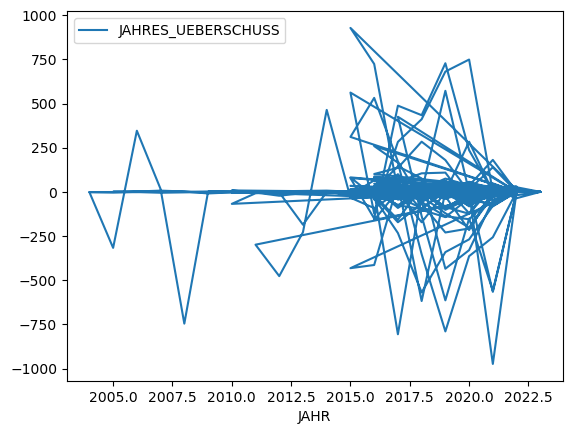

In [178]:
#df_faknz_1[df_faknz_1['WKN'] == '606110'].plot.line(x='JAHR',y='JAHRES_UEBERSCHUSS', subplots=True)
df_faknz_1.plot.line(x='JAHR',y=['JAHRES_UEBERSCHUSS'], subplots=True)
#df_faknz_1.plot(kind='line', x='JAHR',y='JAHRES_UEBERSCHUSS', subplots=True, xticks=[2005:2022])

In [175]:
df_faknz_2 = df_faknz_1.copy()

In [176]:
df_faknz_2.head(30)


,WKN,ARIVA_NAME,JAHR,JAHRES_UEBERSCHUSS,KGV
0,901876,batm_advanced_communications-aktie,2016,-1.000,0
1,901876,batm_advanced_communications-aktie,2017,0.000,0
2,901876,batm_advanced_communications-aktie,2018,0.000,0
3,901876,batm_advanced_communications-aktie,2019,4.000,0
4,901876,batm_advanced_communications-aktie,2020,10.000,0
5,901876,batm_advanced_communications-aktie,2021,14.000,0
6,901876,batm_advanced_communications-aktie,2022,0.000,0
7,606110,hms_bergbau-aktie,2016,0.000,"139,83"
8,606110,hms_bergbau-aktie,2017,1.000,"87,44"
9,606110,hms_bergbau-aktie,2018,1.000,"54,55"
